In [24]:
import pandas as pd
import numpy as np
import random
import time
import matplotlib.pyplot as plt

# Global variabel
# globMK, globT
fightCache = []

# Konfigurasi script
awalConf = 0 # 0 untuk karakter awal random, masukkan ID (bukan index array) jika bukan random
lawanConf = "" # string kosong untuk urutan lawan random, string "+" untuk power ascending, string "-" untuk power descending, Array[id1,id2,...,idN] untuk lawan yang diatur
fmodeRnd = True # True = mode fight pakai probabilitas, False = mode fight pakai komparasi power langsung
isFightCache = True # True = hasil simulasi battle akan disimpan dalam cache internal sehingga pemanggilan yang sama (oleh algoritma yang berbeda) akan mendapat hasil yang sama, False = simulasi dilakukan setiap pemanggilan walaupun jago dan musuh yang sama
isDebug = False
isDropChar = True # True = karakter yang kalah tidak boleh digunakan lagi, False = boleh dipakai lagi
isFileUpload = False # True = file datasource diupload, False = lewat Google Drive
numTrial = 20

In [25]:
if isFileUpload:
  from google.colab import files
  uploaded = files.upload()
  globMK = pd.read_csv(list(uploaded.keys())[0], sep=";")
else: # Hubungkan dengan Google Drive
  from google.colab import drive
  drive.mount('/content/drive/')
  #!ls -al "/content/drive/My Drive/Colab Notebooks/"
  globMK = pd.read_csv("/content/drive/My Drive/Colab Notebooks/mk_characters_with_counters.csv", sep=';')

Mounted at /content/drive/


In [26]:
cid_array = []
for index, row in globMK.iterrows():
  cid = row["Counter_ID"]
  if pd.notna(cid) and (str(cid).strip()!=""):
    daftar = []
    txt = cid.split(",")
    for x in txt:
      x = x.strip()
      if x.isdigit():
        daftar.append(int(x))
  else:
    daftar = []
  cid_array.append(daftar)
globMK["Counter_ID"] = cid_array

#globMK.head()
#print(globMK.iloc[1])

In [27]:
def isMenang(pakai,musuh):
  global globMK, globT

  showDebug("Pakai "+globMK.iloc[pakai]["Nama"]+" vs "+globMK.iloc[musuh]["Nama"])
  pTotal = 100
  globT += 1
  if (pakai+1) in globMK.iloc[musuh]["Counter_ID"]: # kalau jagoan ada di daftar lawan alami musuh, maka...
    if (musuh+1) in globMK.iloc[pakai]["Counter_ID"]: # kalau karakter yang dipakai RUPANYA JUGA lawan alami dari musuh (Equal Counter = saling mengalahkan, jadinya 50:50)
      if fmodeRnd:  # mode fight probabilitas
        pMenang = 50
      else: # mode fight bukan probabilitas (pakai komparasi power)
        if globMK.iloc[pakai]["Power"] >= globMK.iloc[musuh]["Power"]:  # kalau karakternya sama, asumsikan pemain pasti menang
          pMenang = 100
        else:
          pMenang = 0
    else: # karakter yang dipakai lawan alami musuh, TAPI musuh BUKAN lawan alami karakter yang dipakai
      if fmodeRnd:
        pMenang = 60
      else:
        pMenang = 100
  elif (musuh+1) in globMK.iloc[pakai]["Counter_ID"]: # kalau musuh ada di daftar lawan alami, maka...
    if (pakai+1) in globMK.iloc[musuh]["Counter_ID"]: # kalau karakter yang dipakai RUPANYA JUGA lawan alami dari musuh (Equal Counter = saling mengalahkan, jadinya 50:50)
      if fmodeRnd:
        pMenang = 50
      else:
        if globMK.iloc[pakai]["Power"] >= globMK.iloc[musuh]["Power"]:
          pMenang = 100
        else:
          pMenang = 0
    else: # musuh lawan alami karakter yang dipakai, TAPI karakter yang dipakai BUKAN lawan alami musuh
      if fmodeRnd:
        pMenang = 40
      else:
        pMenang = 0
  else: # musuh bukan lawan alami
    if fmodeRnd:
      pMenang = globMK.iloc[pakai]["Power"]
      pTotal = pMenang + globMK.iloc[musuh]["Power"]
    else:
      if globMK.iloc[pakai]["Power"] >= globMK.iloc[musuh]["Power"]:
        pMenang = 100
      else:
        pMenang = 0
  if isFightCache:
    idx = str(pakai)+"-"+str(musuh)
    inCache,valCache = isInMemo(fightCache,idx)
    if inCache:
      menang = valCache
    else:
      menang = random.randint(1,pTotal) <= pMenang
      fightCache.append([idx,menang])
  else:
    menang = random.randint(1,pTotal) <= pMenang
  return (menang)

def showDebug(pesan):
  if isDebug: print(pesan)

def showChart(arrHasil,colName,colTitle,colLabel):
  x = list(range(1, len(arrHasil) + 1))  # Dataset index: 1, 2, 3, ...
  algoCari1 = []
  algoCari2 = []
  algoCari3 = []

  for pair in arrHasil:
    algoCari1.append(pair[0][colName])
    algoCari2.append(pair[1][colName])
    algoCari3.append(pair[2][colName])

  # Plotting
  plt.figure(figsize=(10, 6))
  plt.plot(x, algoCari1, marker='o', label='Greedy', color='blue')
  plt.plot(x, algoCari2, marker='s', label='DP-Memo', color='green')
  plt.plot(x, algoCari3, marker='d', label='InSort-Min', color='red')

  # Labels and title
  plt.title("Perbandingan "+colTitle)
  plt.xlabel('Dataset Ke-')
  plt.ylabel(colLabel)
  plt.xticks(x)
  plt.grid(True)
  plt.legend()
  plt.tight_layout()
  plt.show()

def isInMemo(memo, idx):
  for x in memo:
    if str(x[0])==idx:
      return True, x[1]
  return False, False

def cariGreedy(lawanLoc,awalLoc):
  retval = True
  hasil = []
  belum = globMK.copy()
  if isDropChar: belum.drop([awalLoc],axis=0,inplace=True)
  jago = awalLoc
  hasil.append(awalLoc)
  for musuh,rowData in lawanLoc.iterrows(): # iterasi setiap karakter musuh di df lawanLoc
    if (isMenang(jago,musuh)):  # kalau menang, lanjut lawan berikutnya
      showDebug(str(jago)+" menang lawan "+str(musuh))
      continue
    else: # kalau kalah...
      showDebug(str(jago)+" kalah lawan "+str(musuh))
      if (len(belum)>0):  # masih ada jagoan tersisa?
        # coba carikan jagoan yang bisa kalahkan lawan saat ini...
        dapat = False
        for index,rowData in belum.iterrows():
          showDebug(str(index)+" COBA lawan "+str(musuh))
          if isMenang(index,musuh):
            showDebug(str(index)+" COBA DAN MENANG lawan "+str(musuh))
            jago = index
            dapat = True
            break
        if dapat: # dapat jagoannya?
          hasil.append(jago)
          if isDropChar: belum.drop([jago],axis=0,inplace=True)
        else: # tidak ada jagoan yang bisa kalahkan
          retval = False
          break
      else: # sudah habis jagoannya semua...
        retval = False
        break
  return (retval,hasil)

def cariDPMemo(lawanLoc,awalLoc):
  retval = True
  memo = []
  hasil = []
  belum = globMK.copy()
  if isDropChar: belum.drop([awalLoc],axis=0,inplace=True)
  jago = awalLoc
  menang = False
  hasil.append(awalLoc)
  for musuh,rowData in lawanLoc.iterrows(): # iterasi setiap karakter musuh di df lawanLoc
    memoIdx = str(jago)+"-"+str(musuh)
    sttMemo,valMemo = isInMemo(memo,memoIdx)
    if sttMemo and valMemo: # ada di memo DAN menang
      continue
    else: # ada di memo TAPI kalah --ATAU-- belum ada di memo
      if not sttMemo: # belum ada di memo
        menang = isMenang(jago,musuh)
        memo.append([memoIdx,menang])
      else: # ada di memo, tapi kalah
        menang = valMemo
      if menang:  # kalau menang, lanjut lawan berikutnya
        continue
      else: # kalau kalah...
        if (len(belum)>0):  # masih ada jagoan tersisa?
          # coba carikan jagoan yang bisa kalahkan lawan saat ini...
          dapat = False
          for calon,rowData in belum.iterrows():
            memoIdx = str(calon)+"-"+str(musuh)
            sttMemo,valMemo = isInMemo(memo,memoIdx)
            if sttMemo and valMemo: # ada di memo DAN menang
              jago = calon
              dapat = True
              break
            else:
              if not sttMemo: # belum ada di memo
                menang = isMenang(calon,musuh)
                memo.append([memoIdx,menang])
              else: # ada di memo, tapi kalah
                menang = valMemo
              if menang:
                jago = calon
                dapat = True
                break
          if dapat: # dapat jagoannya?
            hasil.append(jago)
            if isDropChar: belum.drop([jago],axis=0,inplace=True)
          else: # tidak ada jagoan yang bisa kalahkan
            retval = False
            break
        else: # sudah habis jagoannya semua...
          retval = False
          break
  return (retval,hasil)

def cariInSortMin(lawanLoc,awalLoc):
  retval = True
  hasil = []
  belum = globMK.copy()
  if isDropChar: belum.drop([awalLoc],axis=0,inplace=True)
  jago = awalLoc
  hasil.append(awalLoc)
  for musuh,rowData in lawanLoc.iterrows(): # iterasi setiap karakter musuh di df lawanLoc
    if (isMenang(jago,musuh)):  # kalau menang, lanjut lawan berikutnya
      continue
    else: # kalau kalah...
      if (len(belum)>0):  # masih ada jagoan tersisa?
        # coba carikan jagoan yang bisa kalahkan lawan saat ini...
        dapat = False
        power = 1000000000  # asumsi awal power tertinggi, karena dicari power terendah
        for index,rowData in belum.iterrows():
          if isMenang(index,musuh) and (rowData["Power"]<power):  # menang DAN power lebih kecil?
            jago = index
            power = rowData["Power"]
            dapat = True
        if dapat: # dapat jagoannya?
          hasil.append(jago)
          if isDropChar: belum.drop([jago],axis=0,inplace=True)
        else: # tidak ada jagoan yang bisa kalahkan
          retval = False
          break
      else: # sudah habis jagoannya semua...
        retval = False
        break
  return (retval,hasil)

In [28]:
print("Jumlah karakter total:",len(globMK))

Jumlah karakter total: 66


In [29]:
arrHasil = []
for nTrial in range(0,numTrial):
  # Inisialisasi jagoan awal
  if awalConf==0:
    awal = random.randint(0,len(globMK)-1)
  else:
    awal = awal - 1
  print("Karakter awal adalah",globMK.iloc[awal]["Nama"],"dengan power",globMK.iloc[awal]["Power"])

  # Tentukan urutan lawan-lawan yang akan dihadapi
  if lawanConf=="-":
    lawan = globMK.sort_values(by=['Power'],ascending=False).reset_index(drop=True)
  elif lawanConf=="+":
    lawan = globMK.sort_values(by=['Power'],ascending=True).reset_index(drop=True)
  elif lawanConf=="":
    lawan = globMK.sample(frac=1).reset_index(drop=True)
    lawan.drop([0],axis=0,inplace=True)
  else:
    lawan = pd.DataFrame(columns=globMK.columns)
    for x in lawanConf:
      lawan.loc[len(lawan)] = globMK.iloc[x-1]

  arrTrial = []
  # Greedy
  globT = 0
  t1 = int(time.time() * 1000)
  isSelesai, jagoan = cariGreedy(lawan,awal)
  t2 = int(time.time() * 1000)
  arrTrial.append({"Algoritma":"Greedy","Karakter":len(jagoan),"Durasi":(t2-t1),"Global-T":globT,"Selesai":int(isSelesai)})
  if numTrial==1:
    print("Hasil Algoritma Greedy")
    if isSelesai:
      print("  Algoritma BERHASIL")
    else:
      print("  Algoritma GAGAL")
    print("  Durasi\t:",(t2-t1),"milidetik")
    print("  Karakter\t:",len(jagoan))
    print("  Global-T\t:",globT)

  # Dynamic Programming (Memoization)
  globT = 0
  t1 = int(time.time() * 1000)
  isSelesai, jagoan = cariDPMemo(lawan,awal)
  t2 = int(time.time() * 1000)
  arrTrial.append({"Algoritma":"DP-Memo","Karakter":len(jagoan),"Durasi":(t2-t1),"Global-T":globT,"Selesai":int(isSelesai)})
  if numTrial==1:
    print("Hasil Algoritma Dynamic Programming")
    if isSelesai:
      print("  Algoritma BERHASIL")
    else:
      print("  Algoritma GAGAL")
    print("  Durasi\t:",(t2-t1),"milidetik")
    print("  Karakter\t:",len(jagoan))
    print("  Global-T\t:",globT)

  # Insert Min
  globT = 0
  t1 = int(time.time() * 1000)
  isSelesai, jagoan = cariInSortMin(lawan,awal)
  t2 = int(time.time() * 1000)
  arrTrial.append({"Algoritma":"Insertion Sort (min)","Karakter":len(jagoan),"Durasi":(t2-t1),"Global-T":globT,"Selesai":int(isSelesai)})
  if numTrial==1:
    print("Hasil Insertion Sort (min)")
    if isSelesai:
      print("  Algoritma BERHASIL")
    else:
      print("  Algoritma GAGAL")
    print("  Durasi\t:",(t2-t1),"milidetik")
    print("  Karakter\t:",len(jagoan))
    print("  Global-T\t:",globT)

  arrHasil.append(arrTrial)

Karakter awal adalah Ashrah dengan power 72
Karakter awal adalah Kano dengan power 65
Karakter awal adalah Liu Kang (Fire God) dengan power 100
Karakter awal adalah Jax Briggs dengan power 68
Karakter awal adalah Sonya Blade dengan power 68
Karakter awal adalah Taven dengan power 88
Karakter awal adalah Smoke dengan power 70
Karakter awal adalah Reptile dengan power 69
Karakter awal adalah Takeda Takahashi dengan power 77
Karakter awal adalah Liu Kang (Fire God) dengan power 100
Karakter awal adalah DVorah dengan power 71
Karakter awal adalah Geras dengan power 89
Karakter awal adalah Hsu Hao dengan power 45
Karakter awal adalah Nitara dengan power 66
Karakter awal adalah Tremor dengan power 73
Karakter awal adalah Kabal dengan power 69
Karakter awal adalah Jacqui Briggs dengan power 66
Karakter awal adalah Kollector dengan power 60
Karakter awal adalah Tremor dengan power 73
Karakter awal adalah Kira dengan power 52


In [30]:
iterDone = [[0,"Greedy"],[0,"Dynamic Programming (Memoization)"],[0,"Insertion Sort (Min)"]]
for iterHasil in arrHasil:
  n = 0
  for doneData in iterHasil:
    if doneData["Selesai"]:
      iterDone[n][0] += 1
    n += 1

for iterHasil in iterDone:
  print("Keberhasilan algoritma "+iterHasil[1]+": "+str(iterHasil[0])+"/"+str(len(arrHasil))+" ("+str(iterHasil[0] * 100 / len(arrHasil))+"%)")

# Hitung statistik
# Inisialisasi struktur penyimpanan manual
algoList = ["Greedy", "DP-Memo", "Insertion Sort (min)"]
algoMetrics = {
  "Greedy": {"Karakter": [], "Durasi": [], "Global-T": []},
  "DP-Memo": {"Karakter": [], "Durasi": [], "Global-T": []},
  "Insertion Sort (min)": {"Karakter": [], "Durasi": [], "Global-T": []}
}

# Mengumpulkan data
for trial in arrHasil:
  for data in trial:
    algo = data["Algoritma"]
    algoMetrics[algo]["Karakter"].append(data["Karakter"])
    algoMetrics[algo]["Durasi"].append(data["Durasi"])
    algoMetrics[algo]["Global-T"].append(data["Global-T"])

# Menampilkan hasil statistik
print("\nStatistik hasil setiap algoritma:")
for algo in algoList:
  print(f"- {algo}")
  for key in ["Karakter", "Durasi", "Global-T"]:
    values = algoMetrics[algo][key]
    avg_val = sum(values) / len(values)
    min_val = min(values)
    max_val = max(values)
    print(f"  {key:<9}: rata-rata = {avg_val:.2f}, min = {min_val}, max = {max_val}")

Keberhasilan algoritma Greedy: 20/20 (100.0%)
Keberhasilan algoritma Dynamic Programming (Memoization): 20/20 (100.0%)
Keberhasilan algoritma Insertion Sort (Min): 20/20 (100.0%)

Statistik hasil setiap algoritma:
- Greedy
  Karakter : rata-rata = 30.75, min = 29, max = 32
  Durasi   : rata-rata = 57.55, min = 45, max = 82
  Global-T : rata-rata = 118.50, min = 113, max = 125
- DP-Memo
  Karakter : rata-rata = 30.75, min = 29, max = 32
  Durasi   : rata-rata = 56.05, min = 45, max = 77
  Global-T : rata-rata = 118.50, min = 113, max = 125
- Insertion Sort (min)
  Karakter : rata-rata = 35.25, min = 30, max = 42
  Durasi   : rata-rata = 769.25, min = 564, max = 1440
  Global-T : rata-rata = 1716.80, min = 1544, max = 1910


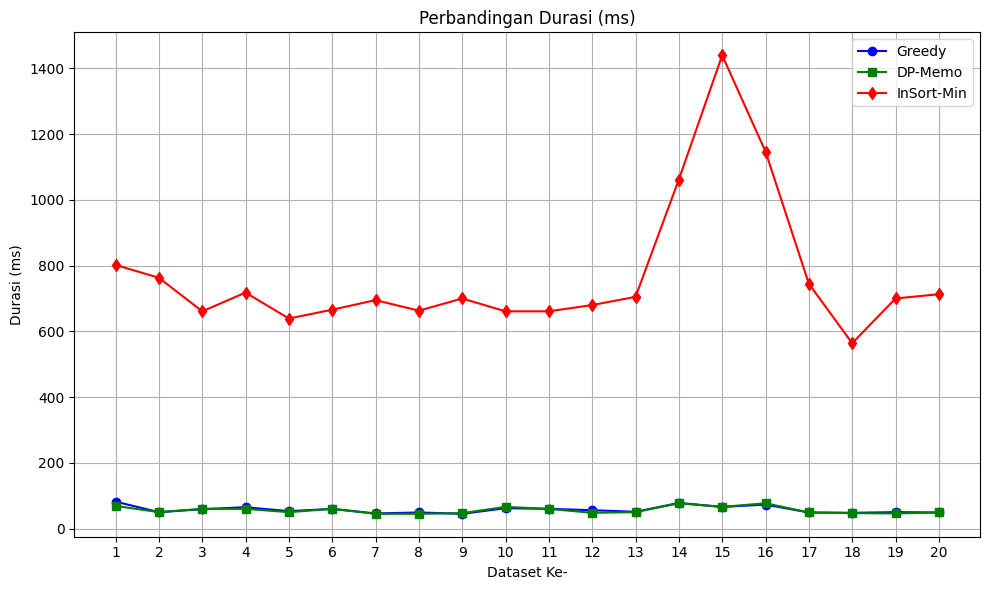

In [31]:
if numTrial>1:
  showChart(arrHasil,"Durasi","Durasi (ms)","Durasi (ms)")

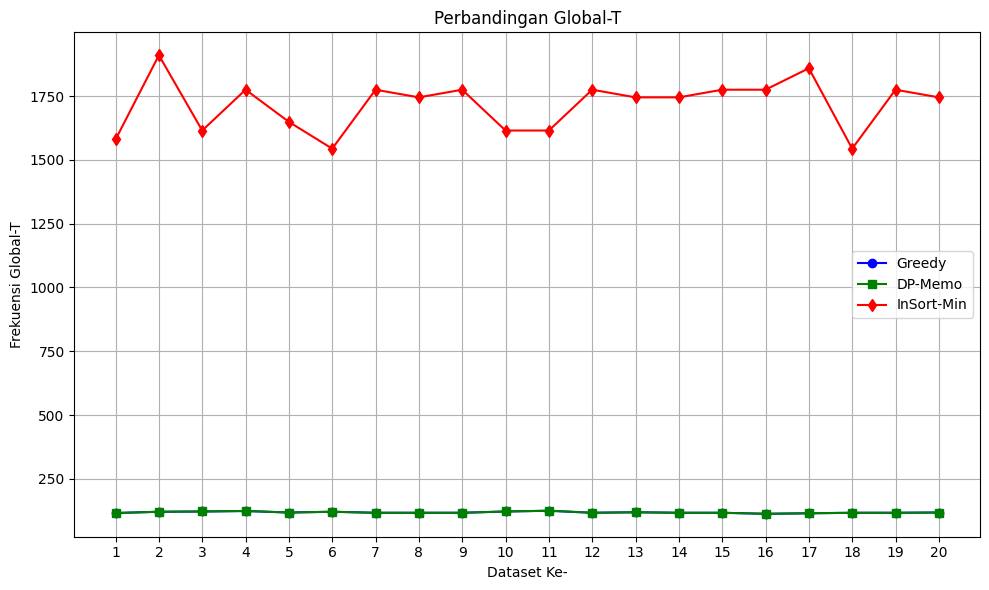

In [32]:
if numTrial>1:
  showChart(arrHasil,"Global-T","Global-T","Frekuensi Global-T")

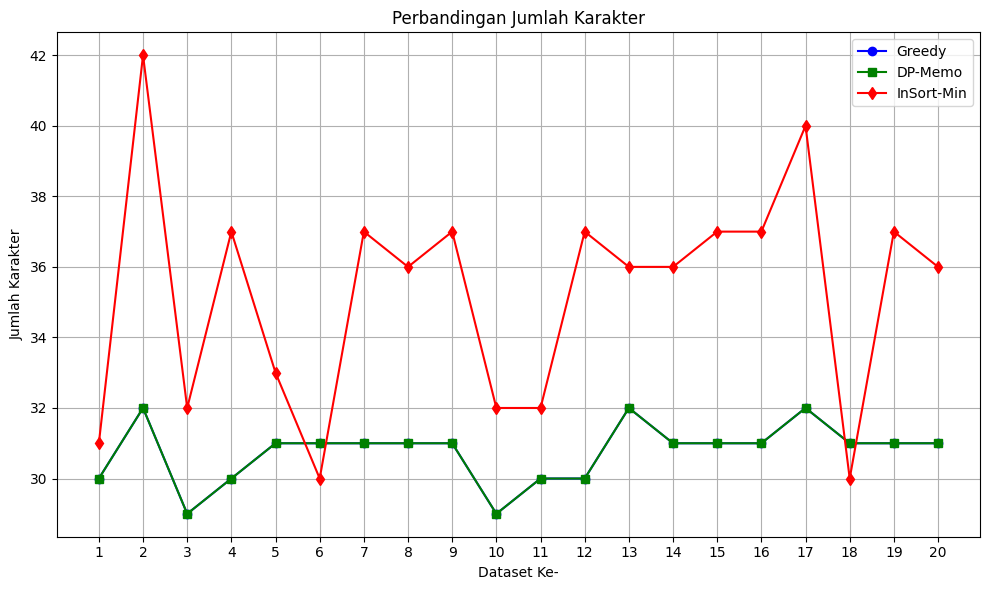

In [33]:
if numTrial>1:
  showChart(arrHasil,"Karakter","Jumlah Karakter","Jumlah Karakter")